# SIFT-RANSAC image registration of x-ray halves



*Unfortunately the batch stitching of x-rays below did not work as good as expected. Need to look at this again. But not now!* 

In [22]:
import numpy as np
import cv2
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import os 
import re 

In [4]:
os.chdir('/media/frank/lonprojecten/2024-811_falnama-project')
os.getcwd()

'/media/frank/lonprojecten/2024-811_falnama-project'

In [36]:
xray_jpgs = sorted(glob('data/interim/xray-jpgs/*.jpg'))
top_jpgs = [jpg for jpg in xray_jpgs if 'top' in jpg]
bot_jpgs = [jpg for jpg in xray_jpgs if 'bottom' in jpg]
jpg_pairs = list(zip(top_jpgs, bot_jpgs))
obj_nums = [re.sub(r'.*(71803-\d\d).*', r'\1', jpg) for jpg in top_jpgs]
stitched_jpgs = [f'{num}_xray-stitched.jpg' for num in obj_nums]
for i, pair in enumerate(jpg_pairs):
    print(f'[{i}] {stitched_jpgs[i]} {pair}')

[0] 71803-01_xray-stitched.jpg ('data/interim/xray-jpgs/71803-01_top_Falnama_grenz_1-2_edited.jpg', 'data/interim/xray-jpgs/71803-01_bottom_Falnama_grenz_2-2_edited.jpg')
[1] 71803-02_xray-stitched.jpg ('data/interim/xray-jpgs/71803-02_top_Falnama_grenz_1-2_edited.jpg', 'data/interim/xray-jpgs/71803-02_bottom_Falnama_grenz_2-2_edited.jpg')
[2] 71803-03_xray-stitched.jpg ('data/interim/xray-jpgs/71803-03_top_Falnama_grenz_1-2_edited.jpg', 'data/interim/xray-jpgs/71803-03_bottom_Falnama_grenz_2-2_edited.jpg')
[3] 71803-04_xray-stitched.jpg ('data/interim/xray-jpgs/71803-04_top_Falnama_grenz_1-2_edited.jpg', 'data/interim/xray-jpgs/71803-04_bottom_Falnama_grenz_2-2_edited.jpg')
[4] 71803-06_xray-stitched.jpg ('data/interim/xray-jpgs/71803-06_top_Falnama_grenz_1-2_edited.jpg', 'data/interim/xray-jpgs/71803-06-bottom_Falnama_grenz_2-2_edited.jpg')
[5] 71803-07_xray-stitched.jpg ('data/interim/xray-jpgs/71803-07_top_Falnama_grenz_1-2_edited.jpg', 'data/interim/xray-jpgs/71803-07_bottom_Falna

<hr> 
2025-04-01  

## First trial of batch stitching (not very nice)

In [18]:
n = 0
top_jpg, bot_jpg = jpg_pairs[n]

In [23]:
obj_nums = [re.sub(r'.*(71803-\d\d).*', r'\1', jpg) for jpg in top_jpgs]

In [24]:
obj_nums

['71803-01',
 '71803-02',
 '71803-03',
 '71803-04',
 '71803-06',
 '71803-07',
 '71803-08',
 '71803-10',
 '71803-11',
 '71803-17',
 '71803-19',
 '71803-20',
 '71803-21',
 '71803-22']

In [37]:
for i, [top_jpg, bot_jpg, stitched_jpg] in enumerate(zip(top_jpgs, bot_jpgs, stitched_jpgs)): 
    print(f'{i} Stitching: {stitched_jpg}...')
    sift_ransac_xray_stitch(top_jpg, bot_jpg, stitched_file=stitched_jpg, outdir='data/interim/xray-jpgs-stitched/', auto_write=True);

0 Stitching: 71803-01_xray-stitched.jpg...
1 Stitching: 71803-02_xray-stitched.jpg...y-jpgs-stitched/71803-01_xray-stitched.jpg...
2 Stitching: 71803-03_xray-stitched.jpg...y-jpgs-stitched/71803-02_xray-stitched.jpg...
3 Stitching: 71803-04_xray-stitched.jpg...y-jpgs-stitched/71803-03_xray-stitched.jpg...
4 Stitching: 71803-06_xray-stitched.jpg...y-jpgs-stitched/71803-04_xray-stitched.jpg...
5 Stitching: 71803-07_xray-stitched.jpg...y-jpgs-stitched/71803-06_xray-stitched.jpg...
6 Stitching: 71803-08_xray-stitched.jpg...y-jpgs-stitched/71803-07_xray-stitched.jpg...
7 Stitching: 71803-10_xray-stitched.jpg...y-jpgs-stitched/71803-08_xray-stitched.jpg...
8 Stitching: 71803-11_xray-stitched.jpg...y-jpgs-stitched/71803-10_xray-stitched.jpg...
9 Stitching: 71803-17_xray-stitched.jpg...y-jpgs-stitched/71803-11_xray-stitched.jpg...
10 Stitching: 71803-19_xray-stitched.jpg...-jpgs-stitched/71803-17_xray-stitched.jpg...
11 Stitching: 71803-20_xray-stitched.jpg...-jpgs-stitched/71803-19_xray-stitc

In [14]:
%matplotlib widget

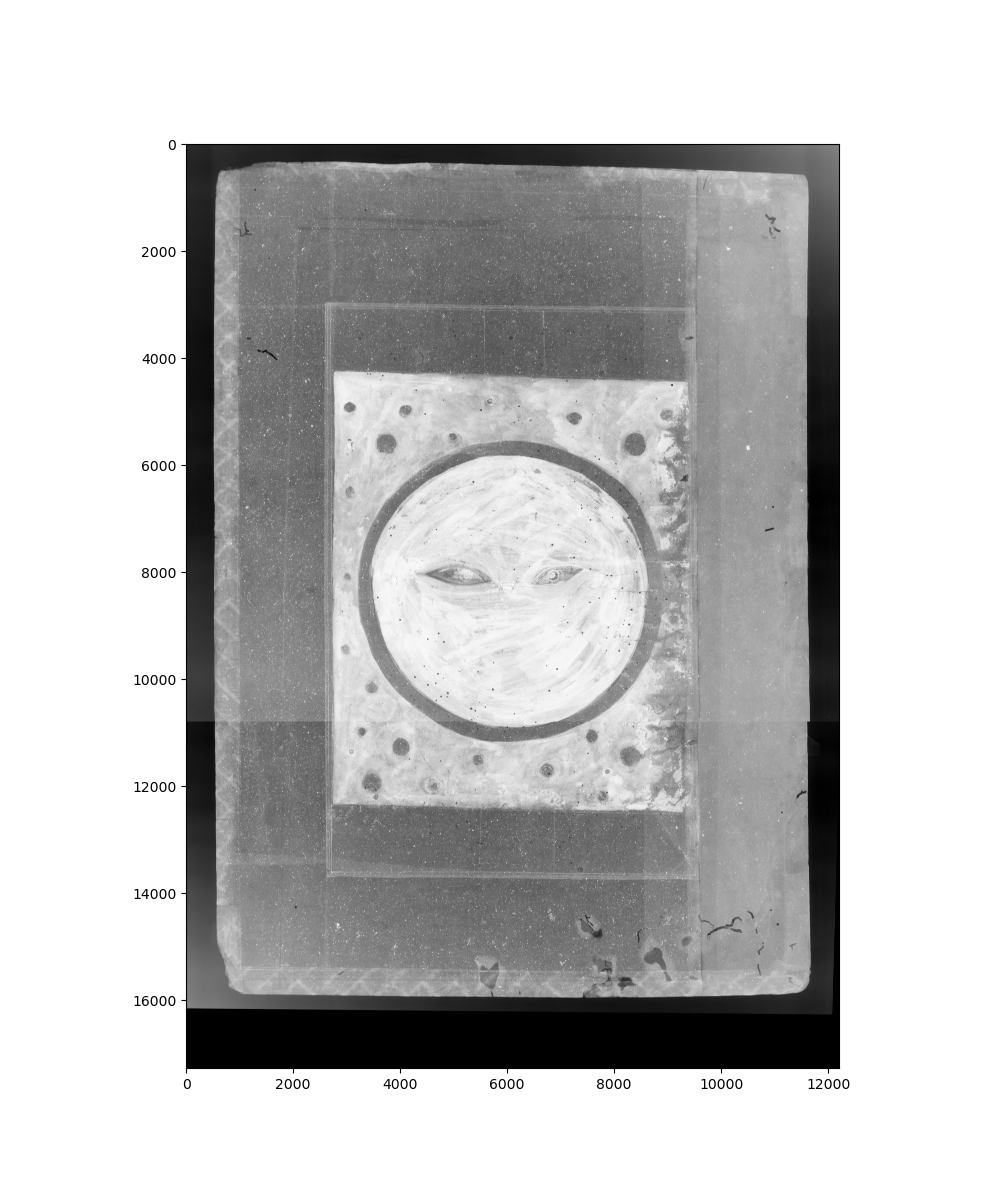

In [33]:
fig, ax = plt.subplots(figsize=[10, 12])
ax.imshow(stitched)

## FUNCTIONS 

In [43]:
def sift_ransac_xray_stitch(im1_path, im2_path, transformation='affine', outdir=None, stitched_file=None, ext='_xray-stitched.png', auto_write=False, scale_x=1, scale_y=1.6, verbose=True): 
    '''Ad hoc code for stitching upper and lower halves of x-ray images. 
    
    `im1_path` should be the upper half and is the destination image, while  
    im2_path is source image and will be warped. 

    If `auto_write` == True, stitched image will be saved to `outdir` + `stitched_file` 

    Returns: im2_aligned (numpy array) 
    '''

    if verbose: 
        print('Loading images...', end='\r')
    
    # Load the images
    im1 = cv2.imread(im1_path)
    im2 = cv2.imread(im2_path)
    
    # Convert images to grayscale for keypoint detection
    im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # SIFT FEATURE DETECTION  
    
    # Initialize SIFT detector: scale-invariant feature transform (you can use ORB if SIFT is not available)
    sift = cv2.SIFT_create()

    if verbose: 
        print('Detecting SIFT keypoints...', end='\r')
    
    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(im1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(im2_gray, None)

    if verbose: 
        print('Matching keypoint pairs...            ', end='\r')
    
    # Use BFMatcher to find the best matches
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    
    # Sort the matches based on distance (best matches first)
    matches = sorted(matches, key=lambda x: x.distance)


    if verbose: 
        print(f'Computing ({transformation}) transformation matrix and warping image...', end='\r')
    
    # Extract the matched keypoints
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # RANSAC TRANSFORMATIONS   
    
    # determine source image shape 
    height, width, _ = im1.shape 
    dst_size = (int(scale_x*width), int(1.6*height))


    if transformation == 'perspective': 
    # Find homography transformation matrix and mask 
        H, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)
        #is_ransac = mask.flatten().astype(bool)

        # Warp the image2 to align it with the (extended) image1
        im2_aligned = cv2.warpPerspective(im2, H, dst_size)

    
    elif transformation == 'affine': 
        # find rigid transformation matrix 
        M, mask = cv2.estimateAffinePartial2D(points1, points2, cv2.RANSAC, 5.0)
        
        #is_ransac = mask.flatten().astype(bool) 

        # Select RANSAC pair points 
        #ransac_points1 = np.array(points1)[is_ransac]
        #ransac_points2 = np.array(points2)[is_ransac]
    
        # Warp the image2 to align it with the (extended) image1
        im2_aligned = cv2.warpAffine(im2, M, dst_size) 

    else: 
        assert False, "transformation option can only be 'affine' or 'perspective'"
    
    
    # Stitch destination image im1 
    h, w, d = im1.shape 
    im2_aligned[0:h, 0:w] = im1 

    # Save stitched image to disk   
    if outdir == None: 
        outdir = os.getcwd() 
        
    if stitched_file == None: 
        stitched_file = im1_path + ext
 
    impath = os.path.join(outdir, stitched_file)

    if auto_write: 

        if verbose: 
            print(f'Saving stitched image to: {impath}...', end='\r')
        
        plt.imsave(impath, im2_aligned)

    return im2_aligned 

In [44]:
n = 0
top_jpg, bot_jpg = jpg_pairs[n]
top_jpg, bot_jpg

('data/interim/xray-jpgs/71803-01_top_Falnama_grenz_1-2_edited.jpg',
 'data/interim/xray-jpgs/71803-01_bottom_Falnama_grenz_2-2_edited.jpg')

In [46]:
both = sift_ransac_xray_stitch(top_jpg, bot_jpg, transformation='perspective')

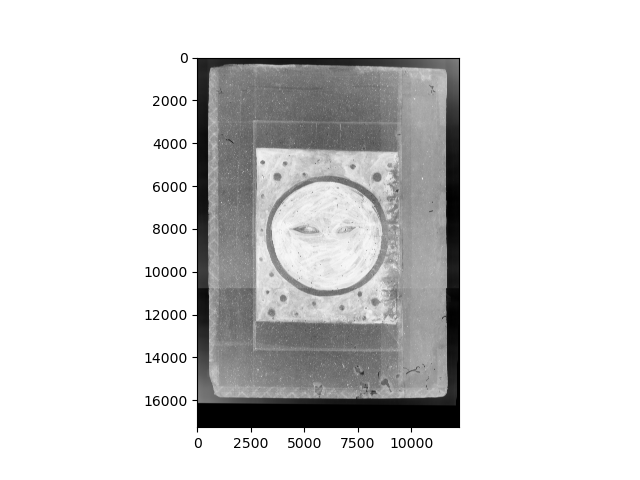

In [47]:
fig, ax = plt.subplots()
ax.imshow(both)